多变量时间序列预测的工作原理与单变量时间序列预测类似。主要的区别是，你必须指定要预测的目标单变量的索引，例如，对于一个5个变量的时间序列，你可能想预测第3个变量的值（我们通过指示target_seq_index = 2来指定）

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from merlion.utils import TimeSeries
from merlion.models.factory import ModelFactory
from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.models.forecast.arima import Sarima, SarimaConfig
from merlion.models.forecast.smoother import MSES, MSESConfig
from merlion.models.forecast.lstm import LSTM, LSTMConfig

from merlion.models.forecast.vector_ar import VectorAR,VectorARConfig
from merlion.models.forecast.boostingtrees import LGBMForecasterConfig,LGBMForecaster
from merlion.models.forecast.baggingtrees import RandomForestForecasterConfig,RandomForestForecaster
from merlion.transform.base import Identity
from merlion.transform.resample import TemporalResample
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig
from merlion.models.factory import ModelFactory

import numpy as np
from sklearn.metrics import accuracy_score

plotly not installed, so plotly visualizations will not work.


In [76]:
# 参数
target_seq_index = 0
max_forecast_steps  = 49
prediction_stride=1
maxlags = 35
n_estimators=100
max_depth=7
learning_rate=0.1
order=(25, 0, 6)

In [4]:
def read_data(name):
    """
    读取数据
    """
    df = pd.read_csv(name)
    df['month'] = pd.to_datetime(df['month'])
    df = df.set_index('month')
    return df

In [64]:
def df_to_timeseries(df):
    """
    转换格式，划分数据集
    """
    time_series_train = TimeSeries.from_pd(df.iloc[:int(df.shape[0]*0.8),:])
    time_series_test = TimeSeries.from_pd(df.iloc[int(df.shape[0]*0.8):,:])
    return time_series_train,time_series_test

In [6]:
def get_target(test):
    """
    获取需要预测的目标变量真值
    """
    target_univariate = test.univariates[test.names[target_seq_index]]
    target = target_univariate[:max_forecast_steps].to_ts()
    return target

In [7]:
def build_model(max_forecast_steps,target_seq_index,order,maxlags):
    """
    构造模型
    """
    config1 = ArimaConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index, order=order)
    model1 = Arima(config1)
    config4 = SarimaConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index, order=(15,0,5),seasonal_order=(2,0,1,24))
    model4 = Sarima(config4)
    config2 = LGBMForecasterConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index,maxlags=maxlags)
    model2 = LGBMForecaster(config2)
    config3 = RandomForestForecasterConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index,maxlags=maxlags)
    model3 = RandomForestForecaster(config3)
    model5 = ModelFactory.create("DefaultForecaster", target_seq_index=target_seq_index, max_forecast_steps=max_forecast_steps)
    
    return model1,model2,model3,model4,model5

In [8]:
def assessment(forecast,df):
    pred = forecast.univariates['closeLogDiff']
    test_df = df.iloc[int(df.shape[0]*0.8):,:]
    test_df['forcast'] = pred
    test_df = test_df[['closeLogDiff','forcast']]
    test_df['true_tend']=np.where(test_df.closeLogDiff >= 0, 1, 0)
    test_df['pred_tend']=np.where(test_df.forcast >= 0, 1, 0)
#     accuracy = accuracy_score(test_df['true_tend'],test_df['pred_tend'])
#     print(f'相同趋势准确率{accuracy:.4f}')
    a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
    b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])
    accuracy = (a+b)/len(test_df)
    print(f'相同趋势准确率{accuracy:.4f}')
    return test_df,accuracy

In [105]:
df6 = read_data('Predict_Data_6.csv')
train6,test6 = df_to_timeseries(df6)
target6 = get_target(test6)
model1,model2,model3,model4,model5 = build_model(max_forecast_steps,target_seq_index,order,maxlags)

In [106]:
train_pred6, train_stderr6 = model3.train(train6)

In [67]:
test6 = test6.univariates

            closeLogDiff  diff(G1000037)_9_abs  diff(G0008003)_12_abs  \
2001-01-01     -0.085514                544.25                    0.6   
2001-02-01     -0.020605               1271.25                    0.5   
2001-03-01      0.004219               1225.00                    0.4   
2001-04-01      0.014296               1353.25                    0.5   
2001-05-01      0.015411               2390.50                    0.7   
...                  ...                   ...                    ...   
2016-11-01      0.024800               6496.75                    0.4   
2016-12-01      0.064264               6478.60                    0.3   
2017-01-01      0.081417               7036.20                    0.3   
2017-02-01      0.104942               6145.75                    0.1   
2017-03-01      0.107965               6192.75                    0.1   

            diff(G0000029)_12  logDiff(G0001596)_12  P9918147_exp  \
2001-01-01                0.6             -0.284451   

In [88]:
inputs = []
for uni in train6.univariates:
    inputs.append(uni.values)
inputs = np.concatenate(inputs, axis=0)

In [96]:
inputs

array([-0.08551447, -0.02060485,  0.00421949, ...,  1.02044715,
        1.55024702,  1.66908465])

In [100]:
train6.univariates['closeLogDiff'].values

[-0.0855144731789703,
 -0.0206048465715051,
 0.0042194892862797,
 0.0142959242354309,
 0.0154112888814614,
 0.0430065782622605,
 0.0244303673486293,
 -0.0357077983849436,
 -0.0400257896487387,
 -0.0215556339562761,
 0.0329353366475489,
 0.0712876053708683,
 0.1169061279218121,
 0.116392750650523,
 0.1120397453310514,
 0.1019358253265348,
 0.0872651787378823,
 0.0650206637480213,
 0.0693280104368392,
 0.0974786981450353,
 0.0961417961010807,
 0.101977808003778,
 0.1447950460296192,
 0.133513585801838,
 0.0672874356902066,
 0.0338495699305392,
 0.0418101261254414,
 0.073179763778359,
 0.0117178654230176,
 0.0536440580457722,
 0.1025914847160376,
 0.1252691478554504,
 0.086059271832925,
 0.0253821156307405,
 0.0252815191378762,
 -0.0139177929632777,
 -0.0271375403904261,
 -0.036415651748515,
 -0.0031828577165298,
 0.0413524382109407,
 0.0791583665203969,
 0.0995695744593871,
 0.0666461442117675,
 0.0658432399930559,
 0.0748689223624474,
 0.0343701402835875,
 -0.0249032807018991,
 -0.09842

In [99]:
np.atleast_2d(train6.univariates['closeLogDiff'].values).reshape(-1)

array([-0.08551447, -0.02060485,  0.00421949,  0.01429592,  0.01541129,
        0.04300658,  0.02443037, -0.0357078 , -0.04002579, -0.02155563,
        0.03293534,  0.07128761,  0.11690613,  0.11639275,  0.11203975,
        0.10193583,  0.08726518,  0.06502066,  0.06932801,  0.0974787 ,
        0.0961418 ,  0.10197781,  0.14479505,  0.13351359,  0.06728744,
        0.03384957,  0.04181013,  0.07317976,  0.01171787,  0.05364406,
        0.10259148,  0.12526915,  0.08605927,  0.02538212,  0.02528152,
       -0.01391779, -0.02713754, -0.03641565, -0.00318286,  0.04135244,
        0.07915837,  0.09956957,  0.06664614,  0.06584324,  0.07486892,
        0.03437014, -0.02490328, -0.09842096, -0.08450108, -0.05673949,
       -0.07336056, -0.07289319, -0.0724308 , -0.02491213,  0.00590081,
       -0.0294868 , -0.01770126,  0.02082333,  0.07913038,  0.06577361,
        0.04613358,  0.06997387,  0.05657057,  0.02729355,  0.00969985,
        0.04144228,  0.02322582,  0.02162363,  0.03995814,  0.06

In [89]:
inputs

array([-0.08551447, -0.02060485,  0.00421949, ...,  1.02044715,
        1.55024702,  1.66908465])

In [86]:
train_pred6

            closeLogDiff
2003-12-01     -0.020244
2004-01-01     -0.017981
2004-02-01     -0.027004
2004-03-01     -0.005500
2004-04-01      0.050877
...                  ...
2016-11-01      0.032482
2016-12-01      0.060658
2017-01-01      0.080207
2017-02-01      0.094022
2017-03-01      0.095535

[160 rows x 1 columns]

In [101]:
forecast6, stderr6 = model3.forecast(time_series_prev = train6,time_stamps = test6.time_stamps)

In [103]:
forecast6

            closeLogDiff
2017-04-01      0.074239
2017-05-01      0.061026
2017-06-01      0.055374
2017-07-01      0.051425
2017-08-01      0.051322
2017-09-01      0.052005
2017-10-01      0.045984
2017-11-01      0.043153
2017-12-01      0.040680
2018-01-01      0.035255
2018-02-01      0.039042
2018-03-01      0.042791
2018-04-01      0.043499
2018-05-01      0.047128
2018-06-01      0.052318
2018-07-01      0.051111
2018-08-01      0.048066
2018-09-01      0.046895
2018-10-01      0.042837
2018-11-01      0.044060
2018-12-01      0.043825
2019-01-01      0.044963
2019-02-01      0.044346
2019-03-01      0.038338
2019-04-01      0.039562
2019-05-01      0.037587
2019-06-01      0.037945
2019-07-01      0.035125
2019-08-01      0.036624
2019-09-01      0.037819
2019-10-01      0.034161
2019-11-01      0.032249
2019-12-01      0.036981
2020-01-01      0.041901
2020-02-01      0.041773
2020-03-01      0.041407
2020-04-01      0.038239
2020-05-01      0.039885
2020-06-01      0.039334


Training Arima...
Training Sarima...
Training LGBMForecaster...
Training RandomForestForecaster...
Training DefaultForecaster...
Arima
RMSE:  0.0343
sMAPE: 120.4217
相同趋势准确率0.7143



<ipython-input-7-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-7-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-7-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


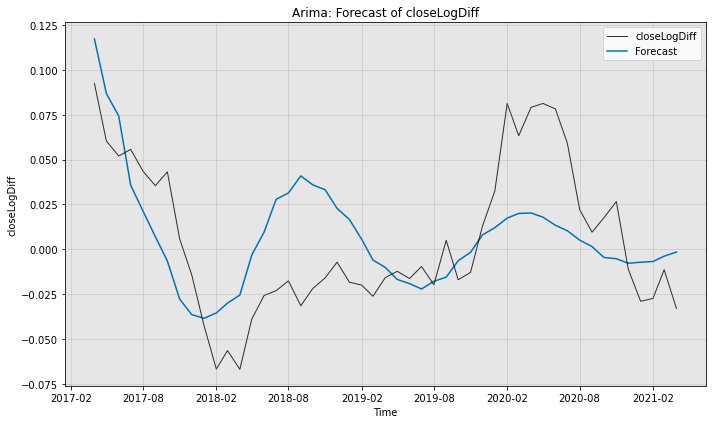

--------------------------分割线---------------------------
Sarima
RMSE:  0.0355
sMAPE: 116.7728
相同趋势准确率0.6939



<ipython-input-7-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-7-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-7-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


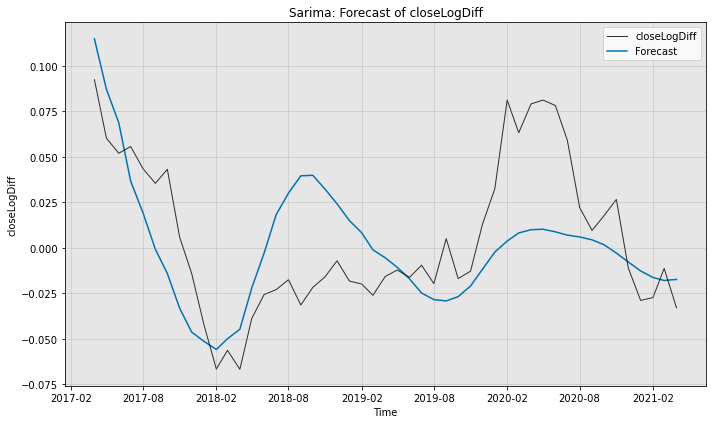

--------------------------分割线---------------------------
LGBMForecaster
RMSE:  0.0703
sMAPE: 114.6757
相同趋势准确率0.7755



<ipython-input-7-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-7-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-7-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


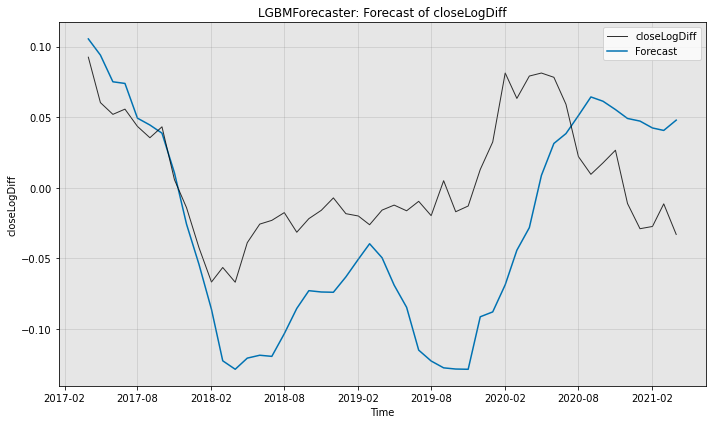

--------------------------分割线---------------------------
RandomForestForecaster
RMSE:  0.0574
sMAPE: 135.2996
相同趋势准确率0.4286



<ipython-input-7-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-7-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-7-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


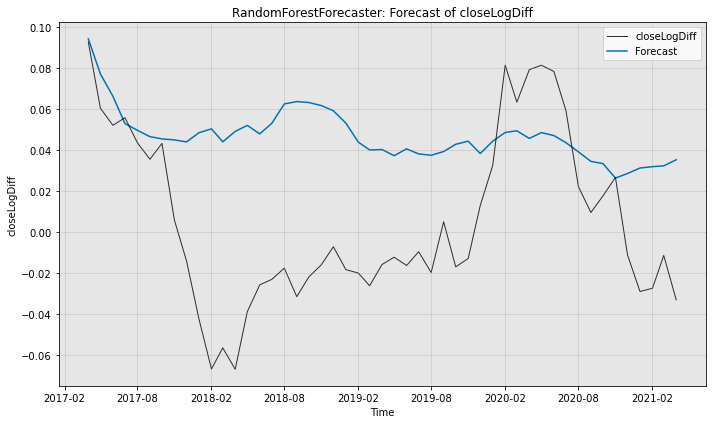

--------------------------分割线---------------------------
DefaultForecaster
RMSE:  0.0899
sMAPE: 134.1386
相同趋势准确率0.6735



<ipython-input-7-1428e82f15e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = pred
<ipython-input-7-1428e82f15e8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-7-1428e82f15e8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


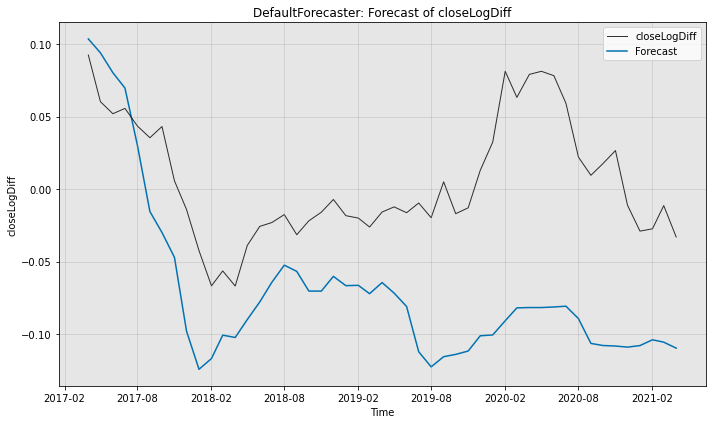

--------------------------分割线---------------------------


In [9]:
if __name__=='__main__':
    df6 = read_data('Predict_Data_6.csv')
    train6,test6 = df_to_timeseries(df6)
    target6 = get_target(test6)
    model1,model2,model3,model4,model5 = build_model(max_forecast_steps,target_seq_index,order,maxlags)

    # 训练模型
    for model in [model1,model4,model2,model3,model5]:
        print(f"Training {type(model).__name__}...")
        train_pred6, train_stderr6 = model.train(train6)
        
        forecast6, stderr6 = model.forecast(target6.time_stamps)
        rmse = ForecastMetric.RMSE.value(ground_truth=target6, predict=forecast6)
        smape = ForecastMetric.sMAPE.value(ground_truth=target6, predict=forecast6)
        print(f"{type(model).__name__}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"sMAPE: {smape:.4f}")
        result_data,accuracy = assessment(forecast6,df6)
        print()
        
        # 可视化
        fig6, ax6 = model.plot_forecast(time_series=test6)
        plt.show()
#        fig6.savefig('C:/Users/TANGLINGHUI331/Desktop/Arima预测_6')
    
        
        print('--------------------------分割线---------------------------')